# 🚀 Workshop: Reinforcement Learning with Flappy Bird 🐦

- **When:** 12 March, 17:00
- **Where:** Appleton Tower, 5.04
- **Contacts:** Reach out on Instagram *@edinburgh.ai*
- **Credits:** Created by EdinburghAI for educational purposes. If you use it, please credit us!

## Today’s Mission 🚀

Today, we'll teach an AI to master **Flappy Bird** using Reinforcement Learning (RL). We'll:
- Set up the Flappy Bird environment
- Explore how RL agents perceive their environment and make decisions
- Understand key RL concepts like state, action, reward, and training loops
- Train our bird to fly autonomously!

Lfg! 🔥

# Setup:

## IMPORTANT! Turn On Internet
1. On the right-hand side of this notebook, there's a section called **"Session Options"**.
2. Scroll down to the _"Internet"_ toggle. Turn it on. You may need to verify your phone number.
3. Additionally, to help this run faster, you can also enable some GPU access.


## Using Jupyter:
This is a Jupyter notebook. It contains cells. There are 2 kinds of cells - markdown and Python. Markdown cells are like this one, and are just there to give you information. Python cells run code. You can run a cell with `Ctrl + Enter` or run a cell and move the next one with `Shift + Enter`. Try running the cell below.

In [1]:
print('Ctrl + Enter runs this cell!')
output = 'The last line of a cell is printed by default'
output

Ctrl + Enter runs this cell!


'The last line of a cell is printed by default'



## 🧩 Introduction to Reinforcement Learning (RL)

In Reinforcement Learning (RL), an agent learns by interacting continuously with an environment. At each step, the agent goes through the following cycle:

- **Agent**: Our bird! In RL, it's normally the AI we're training.
- **Observation (State)**: This is everything that the agent sees. How to setup the environment is not necessarily obvious. For example:
  - We could just feed in the raw pixels of the game.
  - We could feed in the relative locations of the pipes.
  - Or we could feed in the a Lidar scan of everything the bird "sees".
  - Our agent will be able to see just the relative locations of the upcoming pipes.
- **Action (Space)**: These are the set of all possible actions one can take. For our bird, it's quite simple; flap or don't flap. But what about an agent learning to play go? It would be MUCH larger.
- **Reward**: After performing an action, the agent receives a numerical reward. This reward signals whether the action was good or bad, guiding the agent to improve its behavior over time. The rewards for our bird is:
  - +0.1 - every frame it stays alive
  - +1.0 - successfully passing a pipe
  - -1.0 - dying
  - -0.5 - touch the top of the screen
- **Next Observation**: The action then gets fed back into the environment, the environment changes, we make an obvservation and repeat the cycle again.

Here's how the cycle looks visually:

<img src="https://gymnasium.farama.org/_images/AE_loop.png" alt="Reinforcement Learning Cycle" width="500"/>


Our goal is to teach our agent (the Flappy Bird) to navigate through pipes successfully, maximizing its cumulative reward.



# Let's get started! 🧨
We're going to have to install some dependencies first. Run the below cell to get everything we need.

What we're importing:

- **gymnasium & flappy_bird_gymnasium:** Provides the Flappy Bird game environment
- **torch (PyTorch):** Deep learning library for building neural networks
- **collections.deque:** Efficient data structure for our experience replay memory
- **matplotlib & IPython.display:** For visualizing our agent's performance
- **tqdm:** For progress bars during training and downloading

Our code checks if a GPU is available and uses it if possible. GPUs can be 10-100x faster than CPUs for neural network training!

In [6]:
!pip install flappy-bird-gymnasium
!pip install gymnasium
!pip install matplotlib
!pip install torch
!pip install tqdm

# Cell 1: Import necessary libraries
import gymnasium as gym
import flappy_bird_gymnasium
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
import torch.nn.functional as F
from collections import deque
from IPython.display import clear_output, display, HTML
from datetime import datetime
import time
from matplotlib.animation import FuncAnimation
import os
import requests
from tqdm.notebook import tqdm

# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


## Exploring the environment
Let's dive a little more into the actual environment that the model runs in. We spoke about it above briefly. Try fill in the below. Details on this specific environment are [here](https://github.com/markub3327/flappy-bird-gymnasium), and details about interacting with environments are [here](https://gymnasium.farama.org/api/env/#gymnasium.Env.action_space).

In [ ]:
env = gym.make('FlappyBird-v0', render_mode="rgb_array", use_lidar=True)

# Let's look at what information we get from the environment
print("1. What does the observation space look like?")
print(f"Observation space: {env.observation_space}")
print(f"Shape: {env.observation_space.shape}")
print(f"This means we get {env.observation_space.shape[0]} numbers that represent the state\n")



1. What does the observation space look like?
Observation space: Box(-1.0, 1.0, (12,), float64)
Shape: (12,)
This means we get 12 numbers that represent the state



What do these numbers represent? Well, according to their documentation, they are:

- the last pipe's horizontal position
- the last top pipe's vertical position
- the last bottom pipe's vertical position
- the next pipe's horizontal position
- the next top pipe's vertical position
- the next bottom pipe's vertical position
- the next next pipe's horizontal position
- the next next top pipe's vertical position
- the next next bottom pipe's vertical position
- player's vertical position
- player's vertical velocity
- player's rotation

But what about when we set Lidar to false?

In [17]:
env.close()

# What about when we set lidar to false?
env = gym.make('FlappyBird-v0', render_mode="rgb_array", use_lidar=False)

# Let's look at what information we get from the environment
print("1. What does the observation space look like?")
print(f"Observation space: {env.observation_space}")
print(f"Shape: {env.observation_space.shape}")

1. What does the observation space look like?
Observation space: Box(0.0, 1.0, (180,), float64)
Shape: (180,)


In [18]:
print("2. What actions can our agent take?")
print(f"Action space: {env.action_space}")
print(f"Number of possible actions: {env.action_space.n}")
print("In Flappy Bird, action 0 = do nothing, action 1 = flap wings\n")

2. What actions can our agent take?
Action space: Discrete(2)
Number of possible actions: 2
In Flappy Bird, action 0 = do nothing, action 1 = flap wings



In [19]:
initial_state, info = env.reset()
print("3. What does the initial state look like?")
print(f"Initial state: {initial_state}")
print(f"""The state represents: 
      
      - the last pipe's horizontal position
      - the last top pipe's vertical position
      - the last bottom pipe's vertical position
      - the next pipe's horizontal position
      - the next top pipe's vertical position
      - the next bottom pipe's vertical position
      - the next next pipe's horizontal position
      - the next next top pipe's vertical position
      - the next next bottom pipe's vertical position
      - player's vertical position
      - player's vertical velocity
      - player's rotation
      """)


3. What does the initial state look like?
Initial state: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.

/Users/leo/School/Edinburgh AI/workshops/venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")



4. After taking action 'flap':
New state: [ 0.98611111  0.21484375  0.41015625  1.          0.          1.
  1.          0.          1.          0.45898438 -0.9         0.5       ]
Reward: 0.1
Game Over? False


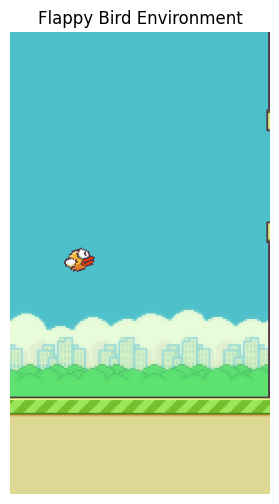

In [14]:
next_state, reward, terminated, truncated, info = env.step(1)  # Take action "flap"
print("\n4. After taking action 'flap':")
print(f"New state: {next_state}")
print(f"Reward: {reward}")
print(f"Game Over? {terminated}")

# Render the environment to see what's happening
frame = env.render()
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.title("Flappy Bird Environment")
plt.axis('off')
plt.show()


In [15]:
env.close()

## 🤔 What is a Q-Network?
A Q-Network is a neural network that estimates "Q-values" - the expected future rewards for taking each possible action in a given state. In Flappy Bird:

- **Input (state_dim):** Features describing the game state (bird's position, pipe positions)
- **Output (action_dim):** Q-values for each possible action (flap or don't flap)
- **Hidden Layer:** Learns patterns and relationships between states and optimal actions

**Note:** Today is about the RL environment and setup, so we don't go too in depth about the network (if you want an overview on them, go to our Sem1 Workshop 1!). For now, just think about it like a black box that takes in inputs and outputs the action it thinks is best. 

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        # Initialize the network
        super(DQN, self).__init__()
        # Define the layers. Note, our model just has a single hidden layer.
        self.fc1 = nn.Linear(state_dim, hidden_dim)

        # Define the output layer. It's the amount of possible outputs (2 for Flappy Bird)
        self.output = nn.Linear(hidden_dim, action_dim)
        
    # Just a simple forward pass of the network. 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        Q = self.output(x)
        return Q

## Ok so I kinda lied.

When I spoke about how we trained it, I implied it works in a loop. It technically does, but there's a bit more to it. In practice, we use a technique called **Experience Replay** to make training more efficient and stable.

Instead of learning from each experience immediately, our agent:
1. Collects experiences (state, action, reward, next state) in a "memory" buffer
2. When it's time to learn, it randomly samples examples from this buffer.
3. Updates its neural network based on these experiences


The `ReplayMemory` class we defined earlier handles this functionality, storing transitions and allowing us to sample from them during training.

In [2]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
        
    def append(self, transition):
        self.memory.append(transition)
        
    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)
    
    def __len__(self):
        return len(self.memory)


## 🕵️ Understanding Key Hyperparameters:

When training a model, there's dials and knobs we can turn to influence the learning process. First, let's explain the exploitation vs exploroation dilemma in RL. 

### Weirdly contrived scenario 👶:
Imagine a weirdly dexterous baby was plopped into a room with a table and some jenga blocks. It's literally never seen jenga blocks before. 

We give the baby sugar when it stacks blocks higher than it has previously. (I.e. The reward function is the height of the tower).

First, it kinda has to learn how to stack blocks. It's gonna try random actions, drop the blocks, and see what happens. But it really quickly discovers that if it stacks it sideways, it gets more sugar, quickly. In it's _exploration phase_, it learned to stack sideways. 

It's able to stack them pretty quickly, pretty high. It learns, _"Hey. This is a tried and tested method. Stack them on their side, get sugar"_. This is the "exploitation phase".

But after around 3 sideways blocks, the tower becomes too unstable and just falls. But because it refuses to try any other method, it's stuck on the 3 block tower. 

If it explored more, it likely would have learned to stack them flat, or in a pyramid. But maybe that would've taken too long to learn. 


### How that contrived example relates to RL:
Our agent starts by trying random actions. It's exploring. The percentage of the time it does something random is called the _exploration rate_. We start with a high exploration rate, and then decrease it as it learns more. There's also a minimum exploration rate, so it never stops exploring completely. 


**Exploration Parameters (Epsilon):**

- `epsilon_init`: We start fully exploratory (100% random actions)
- `epsilon_decay`: After each learning step, we reduce exploration by this factor
- `epsilon_min`: We'll always maintain some exploration (5%)


**Learning Parameters:**

- `learning_rate`: How quickly the neural network updates its weights
- `discount_factor`: How much we value future rewards compared to immediate ones
- `mini_batch_size`: How many experiences we learn from in each update


**Memory Parameters:**

- `replay_memory_size`: How many past experiences we store (100,000)


**Network Parameters:**

- `network_sync_rate`: How often we update the target network
- `fc1_nodes`: Size of our neural network's hidden layer


In [3]:
hyperparameters = {
    # Which environment are we using?
    "env_id": "FlappyBird-v0",
    
    # Memory size for storing past experiences
    "replay_memory_size": 100000,
    
    # Number of experiences to sample for each learning update
    "mini_batch_size": 32,
    
    # Initial exploration rate (1.0 = 100% random actions)
    "epsilon_init": 1.0,
    
    # Rate at which exploration decreases
    "epsilon_decay": 0.9995,
    
    # Minimum exploration rate (never explore less than this)
    "epsilon_min": 0.05,
    
    # How often to update the target network (in steps)
    "network_sync_rate": 10,
    
    # Learning rate for the neural network
    "learning_rate": 0.0001,
    
    # Discount factor for future rewards
    "discount_factor": 0.99,
    
    # Training will stop if agent gets this much reward in one episode
    "max_reward_threshold": 10000,
    
    # Neural network hidden layer size
    "fc1_nodes": 256,
    
    # Parameters about the environment we're going to use.
    # In our case, we just want the locations of the pipes (relative to us), 
    # and not the lidar scanning of the bird. 
    "env_make_params": {"use_lidar": False},
    
    # Stop training on reward threshold
    "stop_on_reward": 10000
}


# 🧠 Creating the Agent

Below is our Agent class that coordinates everything:

- Environment setup
- Decision making (choosing actions)
- Learning from experiences (training)
- Managing trained models

You don't need to fully understand the code, it's beyond scope of today's workshop. You should be able to run it and be fine. 

Below it, we're going to work on the training loop, specifically how the learning rate drops. 

In [ ]:
class Agent:
    def __init__(self):
        # Set hyperparameters
        self.env_id = hyperparameters['env_id']
        self.learning_rate_a = hyperparameters['learning_rate']
        self.discount_factor_g = hyperparameters['discount_factor']
        self.network_sync_rate = hyperparameters['network_sync_rate']
        self.replay_memory_size = hyperparameters['replay_memory_size']
        self.mini_batch_size = hyperparameters['mini_batch_size']
        self.epsilon_init = hyperparameters['epsilon_init']
        self.epsilon_decay = hyperparameters['epsilon_decay']
        self.epsilon_min = hyperparameters['epsilon_min']
        self.stop_on_reward = hyperparameters['stop_on_reward']
        self.fc1_nodes = hyperparameters['fc1_nodes']
        self.env_make_params = hyperparameters.get('env_make_params', {})
        
        # Neural Network loss function
        self.loss_fn = nn.MSELoss()
        self.optimizer = None
        
        # For visualisation in notebook
        self.fig = None
        self.ax = None
        
    def create_environment(self, render_mode="rgb_array"):
        """Create environment with specified render mode"""
        return gym.make(self.env_id, render_mode=render_mode, **self.env_make_params)
        
    # Don't worry too much about this. 
    # This is just how we tell the model it's done something wrong 
    def optimize(self, mini_batch, policy_dqn, target_dqn):
        # Transpose and separate elements
        states, actions, new_states, rewards, terminations = zip(*mini_batch)
        
        # Stack tensors to create batch tensors
        states = torch.stack(states)
        actions = torch.stack(actions)
        new_states = torch.stack(new_states)
        rewards = torch.stack(rewards)
        terminations = torch.tensor(terminations).float().to(device)
        
        with torch.no_grad():
            # Calculate target Q values
            target_q = rewards + (1-terminations) * self.discount_factor_g * target_dqn(new_states).max(dim=1)[0]
        
        # Calculate Q values from current policy
        current_q = policy_dqn(states).gather(dim=1, index=actions.unsqueeze(dim=1)).squeeze()
        
        # Compute loss
        loss = self.loss_fn(current_q, target_q)
        
        # Optimize the model (backpropagation)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

        
    def train(self, num_episodes=1000, update_display_every=5):
        pass  # We'll be making this in the next cell!
    
    # Run a trained model and display gameplay in notebook
    def run_trained_model(self, model_path="best_flappy_model.pt", max_steps=1000, fps=30):
        """
        Run a trained model and display gameplay in a Jupyter notebook
        using matplotlib animation instead of pygame window.
        This method is specifically designed for cloud Jupyter notebooks.
        
        Parameters:
        - model_path: Path to the saved model
        - max_steps: Maximum number of steps to run
        - fps: Frames per second for the display
        
        Returns:
        - Total reward achieved
        """
        # Setup and prepare the visualisation
        frames = self.collect_gameplay_frames(model_path, max_steps)
        
        # Display animation using matplotlib animation
        return self.display_gameplay_animation(frames)
    
    # Separate function to collect gameplay frames
    def collect_gameplay_frames(self, model_path="best_flappy_model.pt", max_steps=1000):
        """Collect frames from the agent playing the game"""
        # Create environment with rgb_array render mode for notebook display
        env = self.create_environment(render_mode="rgb_array")
        
        # Get state and action dimensions
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.n
        
        # Create and load the trained model
        policy_network = DQN(num_states, num_actions, self.fc1_nodes).to(device)
        policy_network.load_state_dict(torch.load(model_path))
        policy_network.eval()  # Set to evaluation mode
        
        # Initialize environment
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float, device=device)
        
        # Game loop variables
        terminated = False
        truncated = False
        total_reward = 0
        frames = []
        step = 0
        
        # Print progress message
        print("Collecting gameplay frames... Please wait.")
        
        # Collect frames while playing
        while not (terminated or truncated) and step < max_steps:
            # Select action based on policy
            with torch.no_grad():
                action = policy_network(state.unsqueeze(dim=0)).squeeze().argmax().item()
            
            # Execute action
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            
            # Convert state to tensor for next iteration
            state = torch.tensor(next_state, dtype=torch.float, device=device)
            
            # Capture frame
            frames.append(env.render())
            
            step += 1
            
            # Show progress periodically
            if step % 50 == 0:
                print(f"Collected {step} frames, current reward: {total_reward:.1f}")
        
        env.close()
        print(f"Game completed! Total reward: {total_reward:.1f}, collected {len(frames)} frames")
        
        return frames
    
    # Display the collected frames as a smooth animation
    def display_gameplay_animation(self, frames):
        """Display collected frames as a smooth animation in the notebook"""
        if not frames:
            print("No frames to display!")
            return 0
            
        print(f"Creating animation with {len(frames)} frames...")
        
        # Create figure for the animation
        fig, ax = plt.subplots(figsize=(8, 6))
        plt.close()  # Close the figure to prevent it from displaying twice
        
        # Initialize with the first frame
        img = ax.imshow(frames[0])
        ax.axis('off')
        
        # Update function for animation
        def update(frame):
            img.set_array(frame)
            return [img]
        
        # Create the animation with a faster interval for smoother playback
        animation = FuncAnimation(
            fig, update, frames=frames, 
            interval=20,  # Smaller interval for smoother animation
            blit=True
        )
        
        # Display the animation in the notebook
        return HTML(animation.to_jshtml())

In [ ]:
# Override the train method
def train(self, num_episodes=1000, update_display_every=5):
    """Train the agent for a specified number of episodes"""
    
    ############################################
    ######## Setting up the model params #######
    ############################################

    # Create instance of environment
    env = self.create_environment()
    
    # Get state and action dimensions
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.n
    
    # Create neural networks
    policy_dqn = DQN(num_states, num_actions, self.fc1_nodes).to(device)
    target_dqn = DQN(num_states, num_actions, self.fc1_nodes).to(device)
    target_dqn.load_state_dict(policy_dqn.state_dict())
    
    # Initialise optimizer
    self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)
    
    # Initialise replay memory
    memory = ReplayMemory(self.replay_memory_size)
    
    # Initialise epsilon
    epsilon = self.epsilon_init
    
    # Lists to track progress
    rewards_per_episode = []
    epsilon_history = []
    step_count = 0
    
    # Initialise best reward
    best_reward = -float('inf')
    best_model_path = "best_flappy_model.pt"
    
    # Create plot for visualisation
    plt.figure(figsize=(12, 5))
    

    ############################################
    ####### Where the model actually learns ####
    ############################################

    # Training loop
    for episode in range(num_episodes):
        # Just some variables for keeping track of things.
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float, device=device)
        terminated = False
        truncated = False
        episode_reward = 0.0
        episode_loss = 0.0
        num_opt_steps = 0
        
        # The main loop for the agent. Runs until a single flappy bird run episode is over. (i.e. dies or is so cracked that it runs infinitely - don't worry, it'll be the first one lol)
        while not (terminated or truncated) and episode_reward < self.stop_on_reward:
            # Select action based on epsilon-greedy
            if random.random() < epsilon:
                # Select random action
                action = env.action_space.sample()
                action = torch.tensor(action, dtype=torch.int64, device=device)
            else:
                # Select best action
                with torch.no_grad():
                    action = policy_dqn(state.unsqueeze(dim=0)).squeeze().argmax()
            
            # Execute action
            new_state, reward, terminated, truncated, _ = env.step(action.item())
            
            # Accumulate rewards
            episode_reward += reward
            
            # Convert new state and reward to tensors
            new_state = torch.tensor(new_state, dtype=torch.float, device=device)
            reward = torch.tensor(reward, dtype=torch.float, device=device)
            
            # Save experience into memory
            memory.append((state, action, new_state, reward, terminated))
            
            # Increment step counter
            step_count += 1
            
            # Train if enough experiences collected
            if len(memory) > self.mini_batch_size:
                mini_batch = memory.sample(self.mini_batch_size)
                loss = self.optimize(mini_batch, policy_dqn, target_dqn)
                episode_loss += loss
                num_opt_steps += 1
                
                # Update the epsilon. We want it to be the bigger of the two:
                # 1. The current epsilon times the decay rate. 
                # 2. The minimum epsilon. 
                epsilon = max(epsilon * self.epsilon_decay, self.epsilon_min)
                
                # Sync networks
                if step_count > self.network_sync_rate:
                    target_dqn.load_state_dict(policy_dqn.state_dict())
                    step_count = 0
            
            # Move to next state
            state = new_state
        
        # Calculate average loss for this episode
        avg_loss = episode_loss / max(1, num_opt_steps)
        
        # Store epsilon at the end of episode
        epsilon_history.append(epsilon)
        
        # Track rewards
        rewards_per_episode.append(episode_reward)
        
        # Update best model
        if episode_reward > best_reward:
            best_reward = episode_reward
            torch.save(policy_dqn.state_dict(), best_model_path)
        
        
        ############################################
        ########### Boring Graphing Code ###########
        ############################################

        # Display progress
        if episode % update_display_every == 0:
            clear_output(wait=True)
            
            # Calculate moving average of rewards
            window_size = min(100, len(rewards_per_episode))
            avg_rewards = [np.mean(rewards_per_episode[max(0, i-window_size):i+1]) 
                          for i in range(len(rewards_per_episode))]
            
            # Create visualisation
            plt.figure(figsize=(12, 5))
            
            # Plot rewards
            plt.subplot(1, 2, 1)
            plt.plot(rewards_per_episode, alpha=0.5, label='Episode Reward')
            plt.plot(avg_rewards, label='Moving Average')
            plt.xlabel('Episode')
            plt.ylabel('Reward')
            plt.legend()
            plt.title(f'Episode {episode}/{num_episodes}, Best Reward: {best_reward:.1f}')
            
            # Plot epsilon decay
            plt.subplot(1, 2, 2)
            plt.plot(epsilon_history)
            plt.xlabel('Episode')
            plt.ylabel('Epsilon')
            plt.title(f'Exploration Rate: {epsilon:.3f}, Avg Loss: {avg_loss:.4f}')
            
            plt.tight_layout()
            plt.show()
    
    ############################################
    ########### MORE Boring Graphing Code ######
    ############################################
    # Final update
    clear_output(wait=True)
    print(f"Training completed! Best reward: {best_reward:.1f}")
    plt.figure(figsize=(12, 5))
    
    # Calculate moving average of rewards
    window_size = min(100, len(rewards_per_episode))
    avg_rewards = [np.mean(rewards_per_episode[max(0, i-window_size):i+1]) 
                  for i in range(len(rewards_per_episode))]
    
    # Plot rewards
    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode, alpha=0.5, label='Episode Reward')
    plt.plot(avg_rewards, label='Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.title(f'Training Complete, Best Reward: {best_reward:.1f}')
    
    # Plot epsilon decay
    plt.subplot(1, 2, 2)
    plt.plot(epsilon_history)
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.title(f'Final Exploration Rate: {epsilon:.3f}')
    
    plt.tight_layout()
    plt.show()
    
    return policy_dqn

# Replace the method in the Agent class
Agent.train = train

In [ ]:

# Cell 6: Functions for workshop usage
def run_training(num_episodes=1000):
    """
    Run a short training session for demonstration purposes
    
    Parameters:
    - num_episodes: Number of episodes to train (default: 50)
    
    Returns:
    - Trained model and agent
    """
    agent = Agent()
    model = agent.train(num_episodes=num_episodes, update_display_every=2)
    return model, agent


In [ ]:
# Now let's run the training for 500 episodes!
run_training(500)


In [ ]:
def visualise_trained_agent(agent=None, model_path="best_flappy_model.pt"):
    """
    visualise a trained agent playing Flappy Bird
    
    Parameters:
    - agent: Agent instance (creates new one if None)
    - model_path: Path to the trained model
    
    Returns:
    - Animation of the agent playing
    """
    if agent is None:
        agent = Agent()
    return agent.run_trained_model(model_path=model_path)

visualise_trained_agent()